Preparing "worst" and "best" subsets per category in dataset bases on hash distance metrics

In [1]:
import numpy as np
#see create_training_paths for creation of the precalculated dcts; 
#due to copyright these may present an issue when uploaded/clash with the open license -> you have to repeat the script yourself
cifar10_hashes = np.load('cifar10_hashes.npz')

In [2]:
hashes, paths = cifar10_hashes['hashes'], cifar10_hashes['paths']

In [205]:
from cifar10_trainer import get_cat
idx = {}
for i,p in enumerate(paths[10000:]):
    idx.setdefault(get_cat(p),[]).append(i+10000)
idx = {k:[min(v),max(v)+1] for k,v in idx.items()}

In [82]:
bit_counts = np.array([int(bin(x).count("1")) for x in range(256)]).astype(np.uint8)
def hamming_dist(a,b,axis=None):
    return np.sum(bit_counts[np.bitwise_xor(a,b)],axis=axis)
def hex2hash(s):
    return np.frombuffer(bytes.fromhex(s), dtype=np.uint8)
def hash2hex(h):
    return h.tobytes().hex()
def calc_inter_dist(hashes, eye_val=1024):
    all_d = np.zeros((hashes.shape[0],hashes.shape[0]),dtype=np.int32)
    for i in range(hashes.shape[0]):
        all_d[i,i+1:] = hamming_dist(hashes[i],hashes[(i+1):], axis=1)
    return all_d+all_d.T+np.eye(hashes.shape[0],dtype=np.int32)*eye_val

In [597]:
def get_best_indices(hashes, reverse = False, remove_transp = True, add_neigh = 0, eye_val=1024):
    sorted_idx, fixed_idx = [], set()
    deactivate_val = max(hashes0[0][0],1024*1024) if reverse else 0
    dists32 = calc_inter_dist(hashes, deactivate_val)
    dists_sqr = dists32*dists32
    deactivate_val_sqr = min(deactivate_val*deactivate_val, np.iinfo(np.int32).max)
    while len(sorted_idx) < hashes.shape[0]-1:
        dists_rows = np.sum(dists_sqr, axis = 0)
        if reverse:
            idx0 = np.argmin(dists_rows) #this row has the smallest overall distances
        else:
            idx0 = np.argmax(dists_rows) #this row has the largest overall distances
        sorted_idx.append(idx0)
        fixed_idx.add(idx0)
        #also add "best" neighbors
        if add_neigh > 0:
            neighbors = np.argsort(dists32[idx0,:])
            if not reverse:
                neighbors = neighbors[::-1]
            for i in range(add_neigh):
                idx1 = neighbors[i]
                if idx1 in fixed_idx:
                    continue
                sorted_idx.append(idx1)
                fixed_idx.add(idx1)
                dists_sqr[:,idx1] = deactivate_val_sqr
                if remove_transp:
                    dists_sqr[idx1,:] = deactivate_val_sqr
        #deactivate added index
        dists_sqr[:,idx0] = deactivate_val_sqr
        if remove_transp:
            dists_sqr[idx0,:] = deactivate_val_sqr
    if len(sorted_idx) < hashes.shape[0]:
        last_idx = list(set(range(hashes.shape[0])).difference(fixed_idx))[0]
        sorted_idx.append(last_idx)
    return sorted_idx

def get_minimal_sets(hashes, idx, reverse = False, remove_transp = True, add_neigh = 0):
    ret_sets = {}
    for k,idx_m in idx.items():
        ret_sets[k] = [i+idx_m[0] for i in get_best_indices(hashes[idx_m[0]:idx_m[1]], reverse=reverse, remove_transp=remove_transp, add_neigh=add_neigh)]
    return ret_sets

hash_sets = {}
for reverse in [True]:
    name0 = 'i' if reverse else 'b'
    for remove_transp in [True, False]:
        name1 = name0 if remove_transp else name0.upper()
        for add_neigh in [0, 1, 2]:
            hash_sets[name1+'%i'%add_neigh] = get_minimal_sets(hashes, idx, reverse = reverse, remove_transp = remove_transp, add_neigh = add_neigh)


In [586]:
hashes0 = hashes[idx['cat'][0]:idx['cat'][0]+16]
reverse=True
remove_transp=False
add_neigh=0

In [481]:
hashes0 = hashes[idx['cat'][0]:idx['cat'][1]]
reverse = False
remove_transp = True
add_neigh = 1
sorted_idx, fixed_idx = [], set()
deactivate_val = max(hashes0[0][0],1024) if reverse else 0
dists32 = calc_inter_dist(hashes0, deactivate_val)

In [558]:
dists_sqr = dists32*dists32
dists_sqr1 = dists_sqr[:6,:6]

In [519]:
dists_sqr = dists32*dists32
deactivate_val_sqr = deactivate_val*deactivate_val

dists_rows = np.sum(dists_sqr, axis = 0)
idx0 = np.argmin(dists_rows) #this row has the smallest overall distances
added_list = [idx0]

In [574]:
def min_max_list(dists_sqr, comb_vers=0):
    max_idx = dists_sqr.shape[0]
    if comb_vers < 2:
        dists_fixed = dists_sqr*(1-np.eye(max_idx,max_idx,dtype=np.int32))
    else:
        max_val = np.max(dists_sqr)+1
        dists_fixed = dists_sqr+np.eye(max_idx,max_idx,dtype=np.int32)*max_val
    all_idx, fixed_idx = list(range(max_idx)), []
    while len(fixed_idx) < max_idx:
        if len(fixed_idx) == 0:
            open_list = all_idx
            check_list = dists_fixed
        else:
            open_list = list(set(all_idx).difference(set(fixed_idx)))
            check_list = dists_fixed[fixed_idx][:,open_list]
        if comb_vers == 0:
            idx0 = np.argmin(np.max(check_list, axis = 0))
        elif comb_vers == 1:
            idx0 = np.argmax(np.max(check_list, axis = 0))
        elif comb_vers == 2:
            idx0 = np.argmin(np.min(check_list, axis = 0))
        else:
            idx0 = np.argmax(np.min(check_list, axis = 0))
        idx1 = open_list[idx0]
        fixed_idx.append(idx1)
    return fixed_idx
#mm1 = min_max_list(dists_sqr, True)

In [569]:
hash_sets.keys()

dict_keys(['w0', 'w1', 'w2', 'W0', 'W1', 'W2', 'b0', 'b1', 'b2', 'B0', 'B1', 'B2'])

In [575]:
def get_minimal_sets2(hashes, idx, comb_vers = 0):
    ret_sets = {}
    for k,idx_m in idx.items():
        dists32 = calc_inter_dist(hashes[idx_m[0]:idx_m[1]], 0)
        dists_sqr = dists32*dists32
        ret_sets[k] = [i+idx_m[0] for i in min_max_list(dists_sqr, comb_vers=comb_vers)]
    return ret_sets

for comb_vers in range(4):
    hash_sets['m%i'%comb_vers] = get_minimal_sets2(hashes, idx, comb_vers)

In [217]:
from build.naphash_cpp import naphash as nhcpp, rot_inv_type
import matplotlib.pyplot as plt
gw = nhcpp(rot_inv_mode=rot_inv_type.none, apply_center_crop=False, is_rgb=False)
gw0 = np.zeros(324,np.float32)
gw.get_norm(gw0)
bytesums = np.asarray([np.sum(gw0[i:i+8]) for i in range(0,320,8)])
bytesumsn = np.int32(256.0/bytesums*16.0/4113.0+0.5)

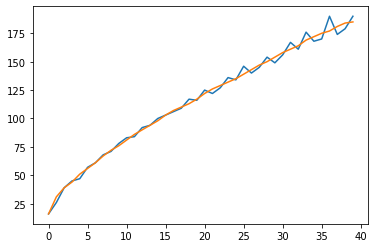

In [395]:
#bytesumsn2[1:] = (bytesumsn2[:-1]+bytesumsn2[1:])/2.0 # applied some smoothing ops
plt.plot(bytesumsn)
plt.plot(np.int32(bytesumsn4+0.5))

In [476]:
dist_w2=np.int32([170, 155, 147, 142, 135, 130, 125, 119, 114, 110, 105, 100,  96,
        92,  88,  83,  79,  76,  73,  69,  64,  60,  57,  54,  51,  47,
        43,  39,  36,  32,  28,  25,  22,  17,  14,  11,   9,   5,   2,
         1])
def hamming_dist_w(a,b,axis=None):
    return np.sum(bit_counts[np.bitwise_xor(a,b)]*dist_w2[:a.shape[0]],axis=axis)
def calc_inter_dist(hashes, eye_val=1024, use_bytes=4):
    all_d = np.zeros((hashes.shape[0],hashes.shape[0]),dtype=np.int32)
    for i in range(hashes.shape[0]):
        all_d[i,i+1:] = hamming_dist_w(hashes[i,:use_bytes],hashes[(i+1):,:use_bytes], axis=1)
    return all_d+all_d.T+np.eye(hashes.shape[0],dtype=np.int32)*eye_val

In [487]:
hash_sets_int ={k0:{k1:[int(i) for i in v1] for k1,v1 in v0.items()} for k0,v0 in hash_sets.items()}

In [489]:
def get_rand_seq(idx):
    retseq = {}
    for k, v in idx.items():
        l0 = list(range(v[0],v[1]))
        np.random.shuffle(l0)
        retseq[k] = np.int32(l0).tolist()
    return retseq
randsets = {'r%i'%i:get_rand_seq(idx) for i in range(10)}

In [579]:
def check_complete(set0, idx):
    for k,v in idx.items():
        s0 = set(set0[k])
        s1 = set(range(v[0],v[1]))
        if len(s0) == len(s1) and len(s0.difference(s1)) == 0:
            continue
        m0, m1 = list(s1.difference(s0)), list(s0.difference(s1))
        print(k, "missing:", m0[:4], len(m0), m1[:4], len(m1))
for k,v in hash_sets.items():
    if k == 'paths':
        continue
    print(k)
    check_complete(v, idx)

w0
airplane missing: [10001, 10002, 10003, 10004] 4998 [] 0
automobile missing: [16384, 16385, 16386, 16387] 4998 [] 0
bird missing: [20001, 20002, 20003, 20004] 4998 [] 0
cat missing: [25001, 25002, 25003, 25004] 4998 [] 0
deer missing: [32768, 32769, 32770, 32771] 4998 [] 0
dog missing: [35001, 35002, 35003, 35004] 4998 [] 0
frog missing: [40001, 40002, 40003, 40004] 4998 [] 0
horse missing: [49152, 49153, 49154, 49155] 4998 [] 0
ship missing: [50001, 50002, 50003, 50004] 4998 [] 0
truck missing: [55001, 55002, 55003, 55004] 4998 [] 0
w1
airplane missing: [10001, 10002, 10003, 10004] 4996 [] 0
automobile missing: [16384, 16385, 16386, 16387] 4997 [] 0
bird missing: [20001, 20002, 20003, 20004] 4997 [] 0
cat missing: [25001, 25002, 25003, 25004] 4997 [] 0
deer missing: [32768, 32769, 32770, 32771] 4998 [] 0
dog missing: [35001, 35002, 35003, 35004] 4997 [] 0
frog missing: [40001, 40002, 40003, 40004] 4996 [] 0
horse missing: [49152, 49153, 49154, 49155] 4997 [] 0
ship missing: [50001,

In [166]:
all_c = list(hash_sets_int.keys())
for i in range(len(all_c)):
    s0 = hash_sets_int[all_c[i]]
    for j in range(i+1,len(all_c)):
        s1 = hash_sets_int[all_c[j]]
        for k in s1.keys():
            if np.all(np.asarray(s0[k]) == np.asarray(s1[k])):
                print(all_c[i], all_c[j], k)

In [600]:
hash_sets.keys()

dict_keys(['i0', 'i1', 'i2', 'I0', 'I1', 'I2'])

In [602]:
sets_old = json.load(open('cifar10_hashsets.json','r'))
rem0 = [k for k in sets_old.keys() if k[0] == 'w' or k[0] == 'W']
for k in rem0:
    sets_old.pop(k)
sets_old.update(hash_sets)
#

In [490]:
hash_sets_int['paths'] = paths.tolist()
hash_sets_int.update(randsets)
import json
json.dump(hash_sets_int, open('cifar10_hashsets2.json','wt'))

In [613]:
!gzip cifar10_hashsets.json

In [618]:
from PIL import Image as pi
from IPython import display as disp0
import numpy as np
import cv2
def show_im(img, is_bgr=True):
    if is_bgr and len(img.shape) > 2 and img.shape[2] == 3:
        img = img[...,::-1] #PIL needs RGB instead of opencv's BGR
    if img.dtype != np.uint8:
        img = (img * (255.499/np.max(img))).astype(np.uint8)  #automatically change HDR range to LDR
    show_impil(pi.fromarray(img))
def show_impil(img):
    disp0.display(img)
def vis_cifar(ids, paths, max_num = 16, fx=2.0):
    ims = [cv2.resize(cv2.imread(paths[i]),(0,0),fx=fx,fy=fx,interpolation=cv2.INTER_NEAREST) for i in ids[:max_num]]
    show_im(np.hstack(ims))

In [ ]:
for k,v in sets_old.items():
    if k == 'paths':
        continue
    print(k)
    vis_cifar(v['cat'], paths)

b0


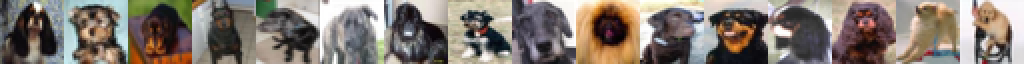

b1


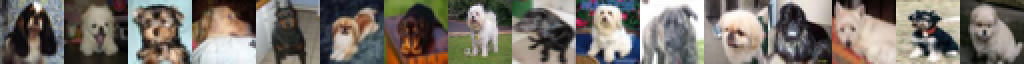

b2


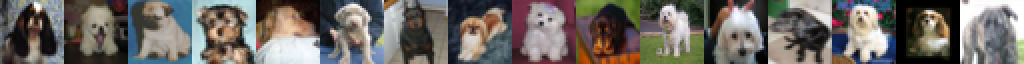

B0


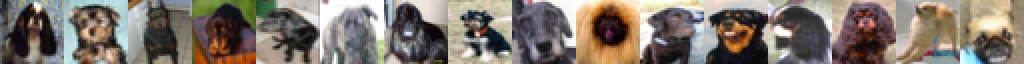

B1


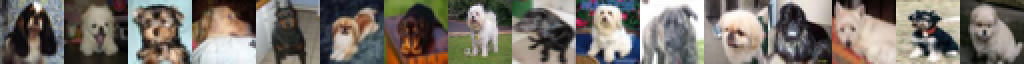

B2


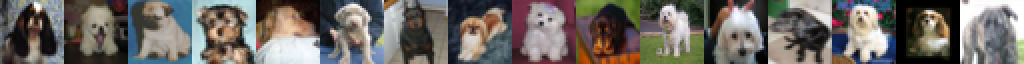

r0


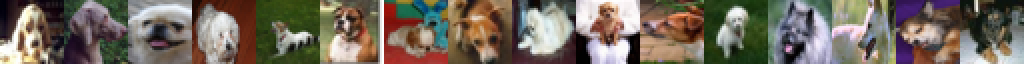

r1


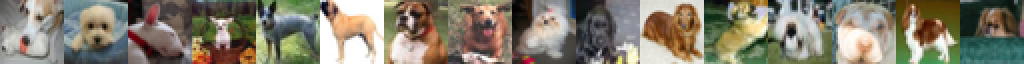

r2


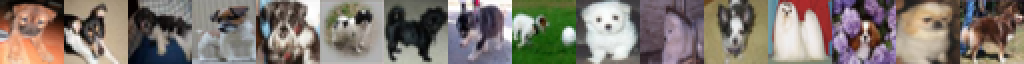

r3


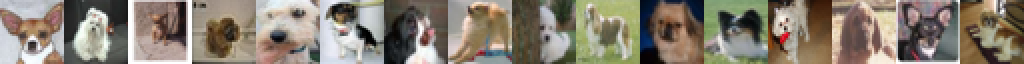

r4


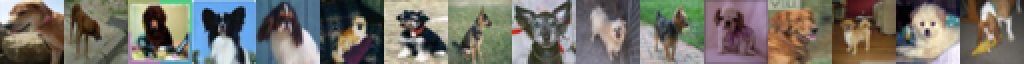

r5


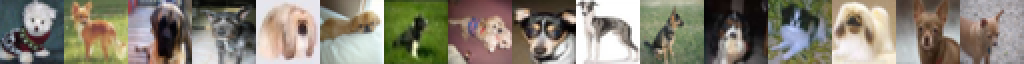

r6


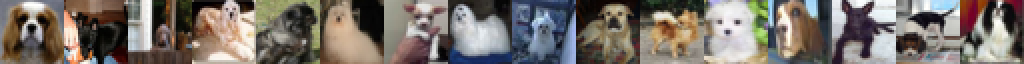

r7


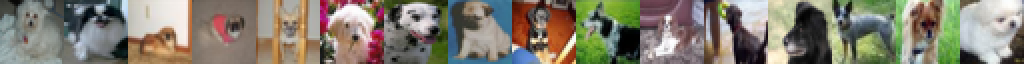

r8


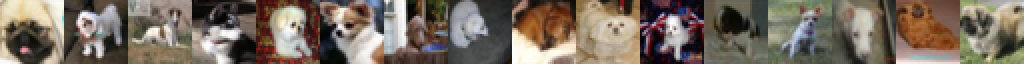

r9


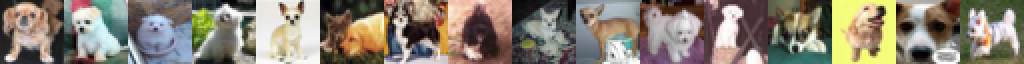

m0


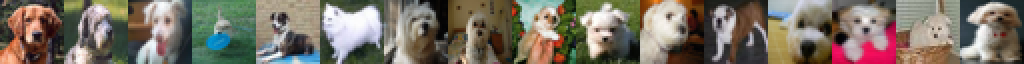

m1


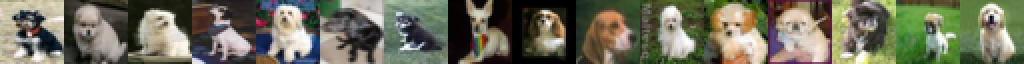

m2


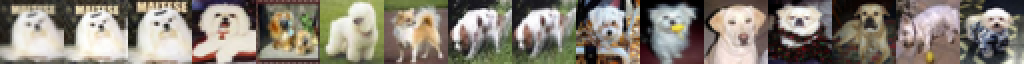

m3


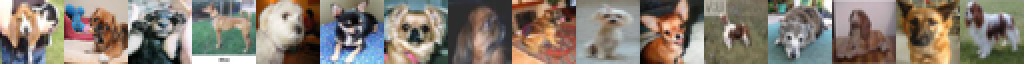

i0


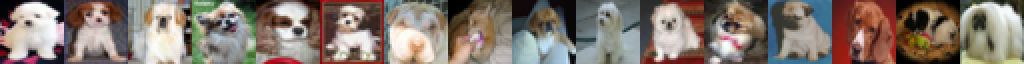

i1


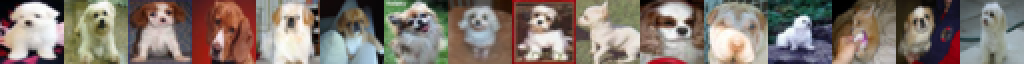

i2


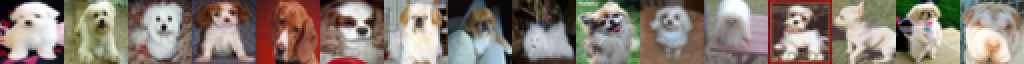

I0


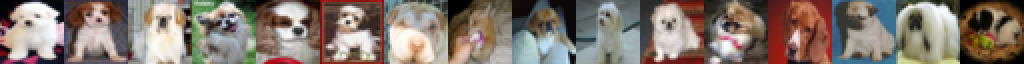

I1


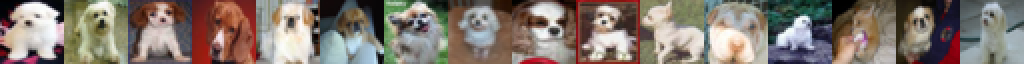

I2


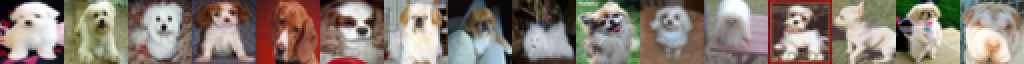

In [616]:
for k,v in sets_old.items():
    if k == 'paths':
        continue
    print(k)
    vis_cifar(v['dog'], paths)

In [196]:
print(list(sorted(hash_sets.keys())))

['B0', 'B1', 'B2', 'W0', 'W1', 'W2', 'b0', 'b1', 'b2', 'paths', 'r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'w0', 'w1', 'w2']
